In [ ]:
#AMR program testing

In [1]:
from piec.drivers.utilities import PiecManager
from piec.measurement_waveforms.magneto_transport import AMR
from piec.drivers.arduino import Arduino_Stepper
from piec.drivers.edc522 import EDC522
from piec.drivers.keithley193a import Keithley193a
from piec.drivers.sr830 import Sr830
pm = PiecManager()


In [2]:
pm.list_resources()

('ASRL3::INSTR', 'GPIB1::9::INSTR', 'GPIB1::10::INSTR', 'GPIB2::8::INSTR')

In [4]:
dmm=Keithley193a("GPIB1::10::INSTR")
calibrator=EDC522('GPIB1::9::INSTR')
arduino=Arduino_Stepper('ASRL3::INSTR')
lockin=Sr830('GPIB2::8::INSTR')

c:\Users\geofr\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyvisa\ctwrapper\highlevel.py:226: VisaIOWarning: VI_WARN_NSUP_ATTR_STATE (1073676420): Although the specified state of the attribute is valid, it is not supported by this implementation.
  return self.handle_return_value(session, ret_value)  # type: ignore


In [7]:
print(dmm.idn())
print(arduino.idn())
print(lockin.idn())

Custom Keithley193a Object at GPIB0::10::INSTR
Custom Arduino_Stepper Object at ASRL3::INSTR
Stanford_Research_Systems,SR830,s/n54854,ver1.07 



In [13]:
calibrator.set_output(0)

'+0000000'

In [12]:
dmm.read_voltage()

0.1

In [9]:
lockin.initialize()

In [ ]:
arduino.step(30,0)

In [ ]:
lockin.configure_gain_filters(sensitivity='')

In [5]:
expirement = AMR(dmm=dmm, calibrator=calibrator, arduino=arduino, lockin=lockin, field=800, angle_step=5, total_angle=360, frequency=17.13, measure_time=100, amplitude=5, save_dir=r"C:\Users\geofr\Desktop\Research\Github\piec\src\piec\notebooks")


In [6]:
expirement.run_experiment()

All instruments working nominally
Set field to 800 Oe and checked it is at 790.0 Oe
capturing data at angle:  0
x:  -0.0011528609899999983 y:  -0.00041161253100000086
Data point at angle 0 degrees and field 800 Oe: X=-0.00149346, Y=-0.000531081
Data point saved to C:\Users\geofr\Desktop\Research\Github\piec\src\piec\notebooks\6_amr_5V_17Hz.csv
capturing data at angle:  5
x:  -0.0011515891599999978 y:  -0.00041107594200000036
Data point at angle 5 degrees and field 800 Oe: X=-0.00149334, Y=-0.000531439
Data point saved to C:\Users\geofr\Desktop\Research\Github\piec\src\piec\notebooks\6_amr_5V_17Hz.csv
capturing data at angle:  10
x:  -0.0011533574699999982 y:  -0.0004116523290000006
Data point at angle 10 degrees and field 800 Oe: X=-0.0014906, Y=-0.000536326
Data point saved to C:\Users\geofr\Desktop\Research\Github\piec\src\piec\notebooks\6_amr_5V_17Hz.csv
capturing data at angle:  15
x:  -0.0011550191999999974 y:  -0.0004122524380000006
Data point at angle 15 degrees and field 800 Oe

Detected start of numeric data at line 6: '0,800,-0.00149346,-0.000531081'


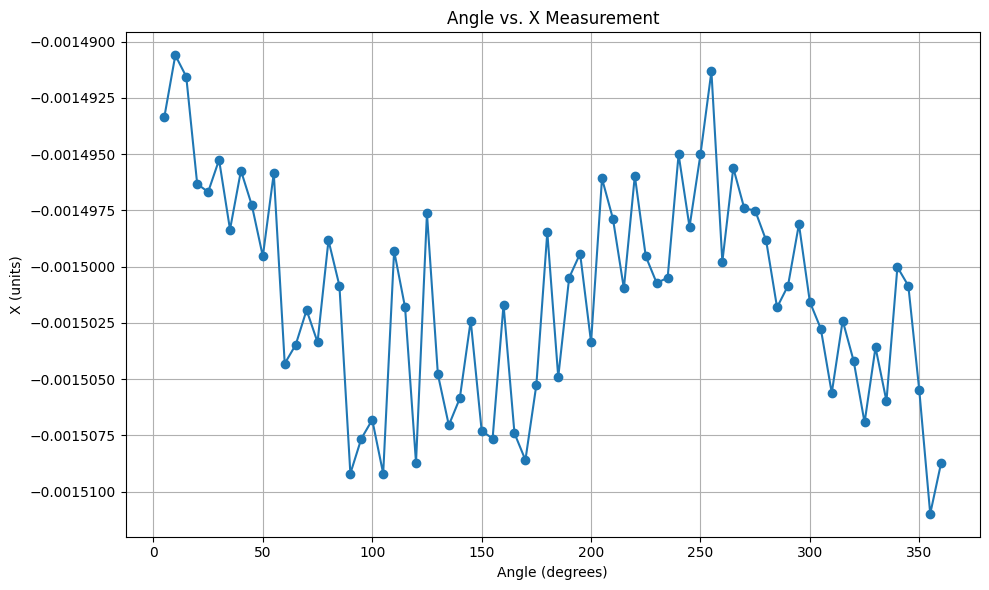

Successfully plotted data from C:\Users\geofr\Desktop\Research\Github\piec\src\piec\notebooks\6_amr_5V_17Hz.csv using assigned column names.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import io

# --- Configuration ---
filename = r'C:\Users\geofr\Desktop\Research\Github\piec\src\piec\notebooks\6_amr_5V_17Hz.csv' # <<< CHANGE THIS TO YOUR FILENAME/PATH
# Define the column names you want to assign
column_names = ['angle', 'field', 'X', 'Y']

# --- Find First Data Row ---
data_start_row_index = None
try:
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            # Clean the line and split by comma
            cleaned_line = line.strip()
            if not cleaned_line: # Skip empty lines
                continue
            
            parts = cleaned_line.split(',')
            
            if not parts: # Skip lines that become empty after split
                continue

            # Try converting the first part to a float to detect numeric data start
            try:
                float(parts[0])
                # If conversion succeeds, this is likely the first data row
                data_start_row_index = i
                print(f"Detected start of numeric data at line {i+1}: '{cleaned_line}'")
                break
            except (ValueError, IndexError):
                # If conversion fails or parts is empty, continue to the next line
                continue
                
except FileNotFoundError:
    print(f"Error: File '{filename}' not found.")
    exit()

if data_start_row_index is None:
    print(f"Error: Could not detect the start of numeric data in {filename}.")
    print("The script expects data rows to start with a number.")
    exit()

# --- Read Data ---
try:
    # Read the CSV data:
    # 1. Skip rows *up to* the detected data start row.
    # 2. Specify that there is NO header row in the file (header=None).
    # 3. Assign the desired column names.
    df = pd.read_csv(filename,
                     skiprows=data_start_row_index,
                     header=None, # Crucial: Tell pandas there's no header row to read
                     names=column_names, # Assign the names directly
                     # Optional: Specify engine if issues arise
                     # engine='python'
                    )

    # --- Basic Data Validation ---
    required_columns = ['angle', 'X'] # Columns needed for the plot

    # Check if expected number of columns were read
    if len(df.columns) < len(column_names):
         print(f"Warning: Expected {len(column_names)} columns based on names provided, but read {len(df.columns)}.")
         print(f"Assigned names: {list(df.columns)}")
         # Adjust required_columns if necessary, or handle error
         if not all(col in df.columns for col in required_columns):
             print(f"Error: Could not find required plotting columns {required_columns} after assigning names.")
             exit()


    # Ensure required columns are numeric
    for col in required_columns:
        # Use errors='coerce' to turn non-numeric values into NaN (Not a Number)
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Remove rows where required columns could not be converted to numbers
    original_rows = len(df)
    df.dropna(subset=required_columns, inplace=True)
    removed_rows = original_rows - len(df)
    if removed_rows > 0:
        print(f"Warning: Removed {removed_rows} rows due to non-numeric values in required columns ('angle', 'X').")


    if df.empty:
      print(f"Error: No valid numeric data found in '{required_columns}' columns after cleaning.")
      exit()

    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    plt.plot(df['angle'], df['X'], marker='o', linestyle='-') # Use the assigned column names

    # --- Customize Plot ---
    plt.title('Angle vs. X Measurement')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('X (units)')
    plt.grid(True)
    plt.tight_layout()

    # --- Show Plot ---
    plt.show()

    print(f"Successfully plotted data from {filename} using assigned column names.")

except pd.errors.EmptyDataError:
    print(f"Error: No data found after skipping {data_start_row_index} lines in '{filename}'.")
except KeyError as e:
     # This error is less likely now since we assign names, but keep for safety
     print(f"Error: A required column '{e}' was not found. This shouldn't happen with assigned names.")
     print(f"Columns present: {list(df.columns)}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")